In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import os
import torch
import glob
import random

Using device: cpu
Classes: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Number of classes: 10
Training samples: 2301
Test samples: 1025


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Step [0/72], Loss: 2.4936
Epoch [1/25], Step [50/72], Loss: 0.8359
Epoch [1/25], Loss: 0.9361, Accuracy: 54.34%
Epoch [2/25], Step [0/72], Loss: 0.6898
Epoch [2/25], Step [50/72], Loss: 0.3553
Epoch [2/25], Loss: 0.5625, Accuracy: 55.12%
Epoch [3/25], Step [0/72], Loss: 0.6947
Epoch [3/25], Step [50/72], Loss: 0.5293
Epoch [3/25], Loss: 0.5621, Accuracy: 56.39%
Epoch [4/25], Step [0/72], Loss: 0.3971
Epoch [4/25], Step [50/72], Loss: 0.2712
Epoch [4/25], Loss: 0.3696, Accuracy: 59.51%
Epoch [5/25], Step [0/72], Loss: 0.2099
Epoch [5/25], Step [50/72], Loss: 0.6393
Epoch [5/25], Loss: 0.3390, Accuracy: 62.05%
Epoch [6/25], Step [0/72], Loss: 0.2395
Epoch [6/25], Step [50/72], Loss: 0.1439
Epoch [6/25], Loss: 0.3311, Accuracy: 64.88%
Epoch [7/25], Step [0/72], Loss: 0.1749
Epoch [7/25], Step [50/72], Loss: 0.4445
Epoch [7/25], Loss: 0.2829, Accuracy: 64.29%
Epoch [8/25], Step [0/72], Loss: 0.2253
Epoch [8/25], Step [50/72], Loss: 0.3911
Epoch [8/25], Loss: 0.2318, Accuracy:

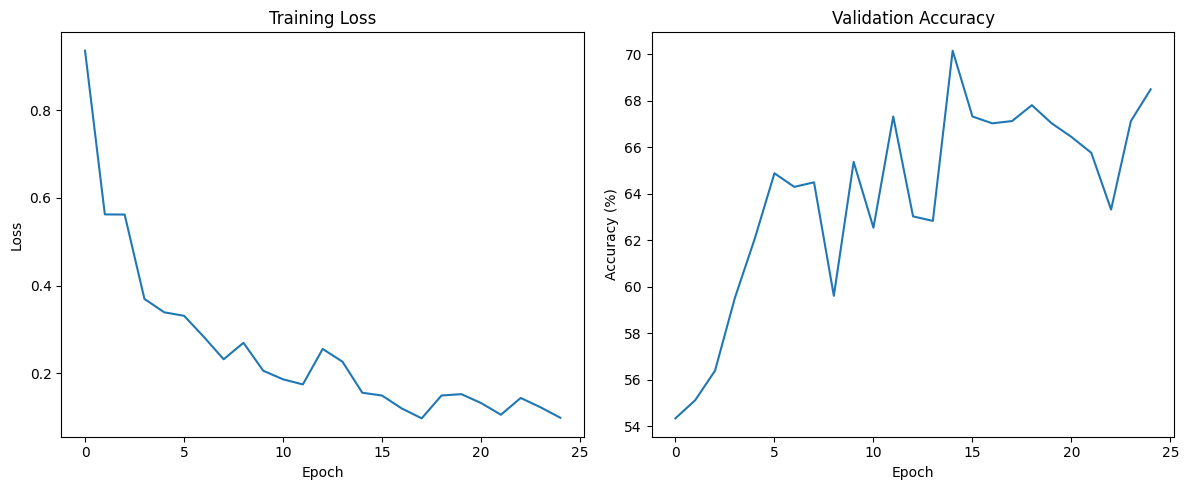

Model saved!


In [3]:
# Проверка устройства
# Выбираем, ГДЕ будем запускать нейросеть.
# torch.cuda.is_available() - проверяем, есть ли видеокарта
# Если ДА → "cuda" (ввидеокарта)
# Если НЕТ → "cpu" (процессор)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Преобразования для тренировочных данных
train_transform = transforms.Compose([
    # Изменение размера. Берет ЛЮБУЮ картинку и делает ее РОВНО 224x224 пикселя
    transforms.Resize((224, 224)),

    # Случайное отражение. С вероятностью 50% переворачивает картинку как в зеркале
    transforms.RandomHorizontalFlip(),

    # Случайный поворот. Поворачивает картинку на случайный угол от -10 до +10 градусов
    transforms.RandomRotation(10),

    # Изменение цветов. Меняет яркость и контраст картинки. Учит сеть распознавать фрукты при разном освещении.
    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    # Преобразование в тензор
    # Из чисел 0-255 в числа 0.0-1.0
    # Меняет порядок измерений
    transforms.ToTensor(),

    # Нормализация. Приводит все картинки к одному стандарту по формуле: (пиксель - среднее) / стандартное_отклонение
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Такой же конвейер, но для тестовых данных. НЕТ аугментаций (RandomHorizontalFlip, RandomRotation, ColorJitter)
# Аугментация - создание новых обучающих данных путем внесения небольших изменений в существующие
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка данных
def load_data(data_path):
    train_path = os.path.join(data_path, 'train')
    test_path = os.path.join(data_path, 'test')
    
    # Загружаем тренировочные и тестовые данные
    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
    test_dataset = datasets.ImageFolder(root=test_path, transform=val_transform)
    
    return train_dataset, test_dataset

# Загрузка модели ResNet
def create_resnet_model(num_classes, pretrained=True):
    # Доступные модели: resnet18, resnet34, resnet50, resnet101, resnet152
    # Создаем модель ResNet18.
    # pretrained=True - берем сеть, УЖЕ обученную на миллионах картинок.
    model = models.resnet18(pretrained=pretrained)
    
    # Заменяем последний слой сети
    # model.fc - последний слой (fully connected)
    # model.fc.in_features - сколько входов у этого слоя (512 для ResNet18)
    # num_classes - сколько выходов (сколько у нас фруктов)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

# Функция обучения
# model - наша нейросеть
# train_loader - данные для обучения
# val_loader - данные для проверки
# criterion - функция потерь
# optimizer - оптимизатор
# epochs - сколько раз пройти по всем данным
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25):
    model = model.to(device)
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        # Что включает:
        # Dropout (если есть)
        # BatchNorm в режиме обучения
        # Подготовку к обновлению весов
        model.train()

        # Создаем переменную для суммы потерь в этой эпохе.
        running_loss = 0.0
        
        # Цикл по всем пакетам данных
        # train_loader выдает по одному батчу за раз:
        # images - картинки
        # labels - правильне ответы
        # batch_idx - номер текущего батча
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            # Пропускаем картинки через нейросеть
            outputs = model(images)

            # Считаем, насколько сеть ошиблась
            loss = criterion(outputs, labels)
            
            # Backward pass
            # ОБНУЛЯЕМ градиенты с предыдущего шага.
            # В PyTorch градиенты накапливаются. Если не обнулить, они будут складываться!
            optimizer.zero_grad()

            # Обратное распространение ошибки
            # Считаются градиенты для КАЖДОГО веса в сети
            # Градиенты показывают, в какую сторону менять веса, чтобы уменьшить ошибку
            loss.backward()

            # Обновляем веса сети.
            # Оптимизатор смотрит на градиенты и немного меняет веса.
            optimizer.step()


            #  Добавляем текущую потерю к общей сумме.
            # .item() - превращает тензор в обычное число.
            running_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Validation phase
        # Выключает Dropout
        # BatchNorm в режиме инференса
        # Инференс — это процесс применения уже обученной модели машинного обучения для получения предсказаний на новых данных
        # Градиенты НЕ считаются
        model.eval()
        correct = 0
        total = 0
        
        # Не считаем градиенты
        # При тестировании градиенты не нужны
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Пропускаем тестовые данные через сеть.
                outputs = model(images)

                # Находим класс с максимальной вероятностью.
                # Пример:
                # outputs = [[0.7, 0.2, 0.1], [0.1, 0.8, 0.1]]
                # predicted = [0, 1] (первая картинка - класс 0, вторая - класс 1)
                _, predicted = torch.max(outputs.data, 1)
                
                # Увеличиваем общий счетчик на размер батча.
                total += labels.size(0)

                # Считаем количество правильных предсказаний.
                correct += (predicted == labels).sum().item()
        
        # Считаем СРЕДНЮЮ потерю за эпоху. len(train_loader) - количество батчей.
        epoch_loss = running_loss / len(train_loader)
        
        # Считаем точность в процентах.
        epoch_accuracy = 100 * correct / total
        
        # Сохраняем результаты для графиков.
        train_losses.append(epoch_loss)
        val_accuracies.append(epoch_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    
    return train_losses, val_accuracies

# Основной код
if __name__ == "__main__":
    # Путь к данным
    data_path = "fruits_data/MY_data"
    
    # Загрузка данных
    train_dataset, test_dataset = load_data(data_path)
    
    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"Classes: {train_dataset.classes}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Создание модели
    num_classes = len(train_dataset.classes)
    model = create_resnet_model(num_classes, pretrained=True)
    
    # Loss function и optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Обучение
    train_losses, val_accuracies = train_model(
        model, train_loader, test_loader, criterion, optimizer, epochs=25
    )
    
    # Визуализация
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Сохранение модели
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': train_dataset.classes,
        'model_architecture': 'resnet18'
    }, 'fruits_resnet18.pth')
    
    print("Model saved!")

In [12]:
api = KaggleApi()

os.makedirs('fruits_data', exist_ok=True)

os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

api.authenticate()

api.dataset_download_files("karimabdulnabi/fruit-classification10-class", path='fruits_data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class


Доступные классы: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Найдено 89 изображений для класса Apple
Найдено 106 изображений для класса Banana
Найдено 105 изображений для класса avocado
Найдено 105 изображений для класса cherry
Найдено 105 изображений для класса kiwi
Найдено 105 изображений для класса mango
Найдено 97 изображений для класса orange
Найдено 105 изображений для класса pinenapple
Найдено 105 изображений для класса watermelon

Всего найдено 180 тестовых изображений

Тестируем на 20 случайных изображениях:

--- Изображение 1 ---


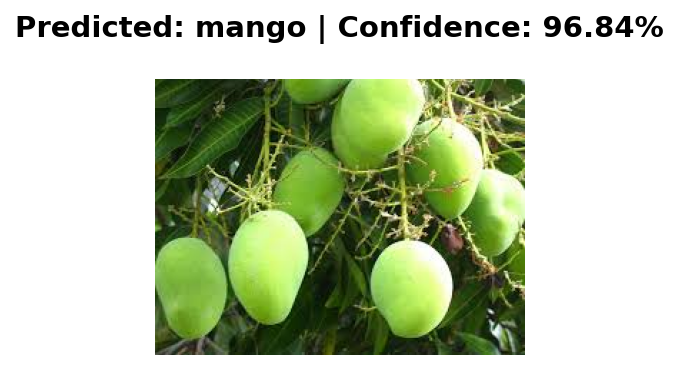

Предсказание: mango
Уверенность: 0.9684
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\mango\img_1081.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 2 ---


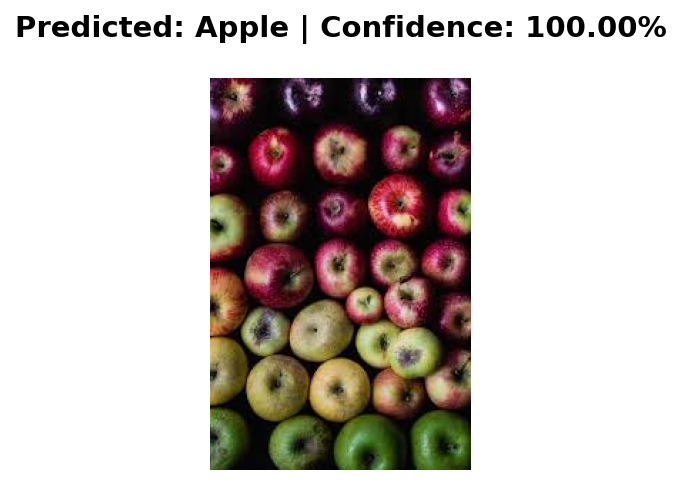

Предсказание: Apple
Уверенность: 1.0000
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\Apple\img_1111.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 3 ---


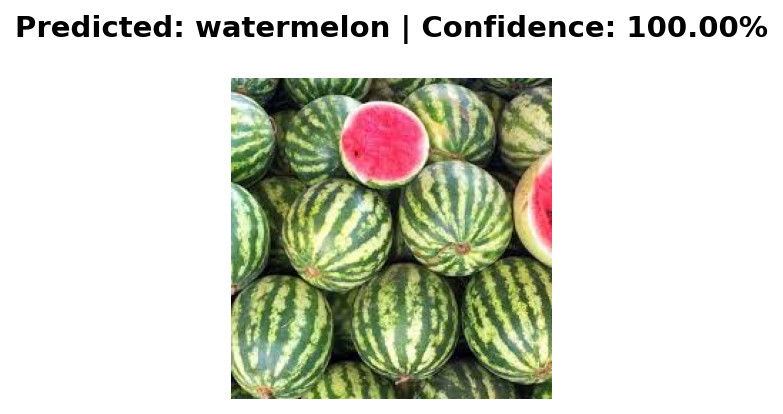

Предсказание: watermelon
Уверенность: 1.0000
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\watermelon\img_1051.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 4 ---


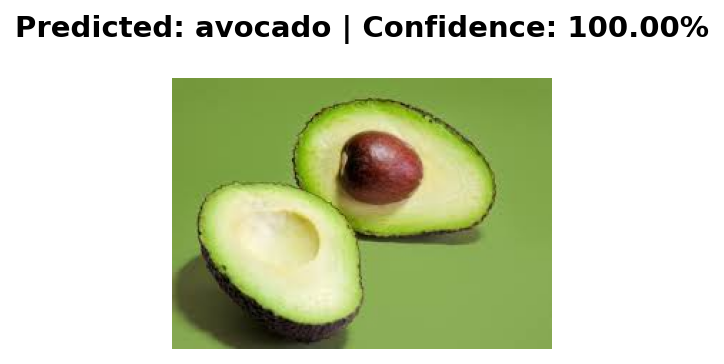

Предсказание: avocado
Уверенность: 1.0000
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\avocado\img_1091.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 5 ---


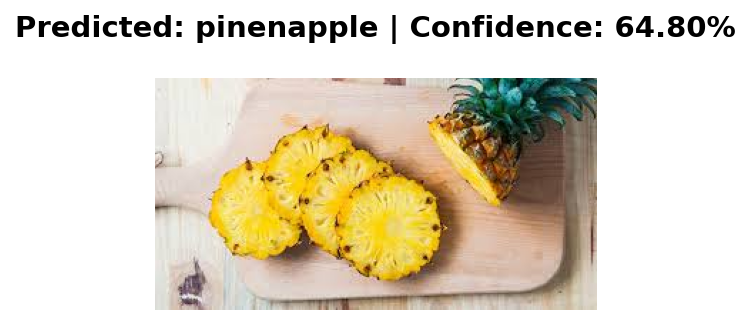

Предсказание: pinenapple
Уверенность: 0.6480
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\pinenapple\img_101.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 6 ---


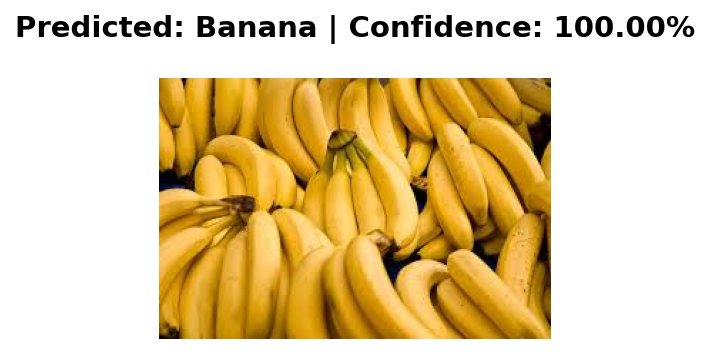

Предсказание: Banana
Уверенность: 1.0000
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\Banana\img_01.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 7 ---


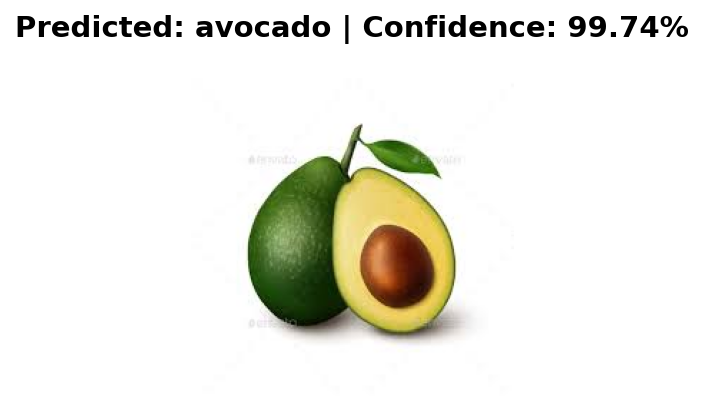

Предсказание: avocado
Уверенность: 0.9974
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\avocado\img_1151.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 8 ---


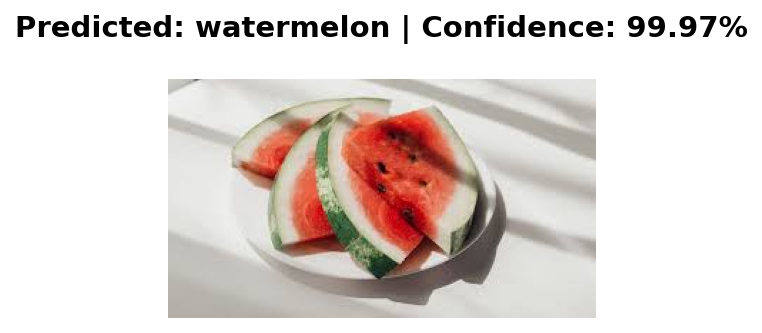

Предсказание: watermelon
Уверенность: 0.9997
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\watermelon\img_11.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 9 ---


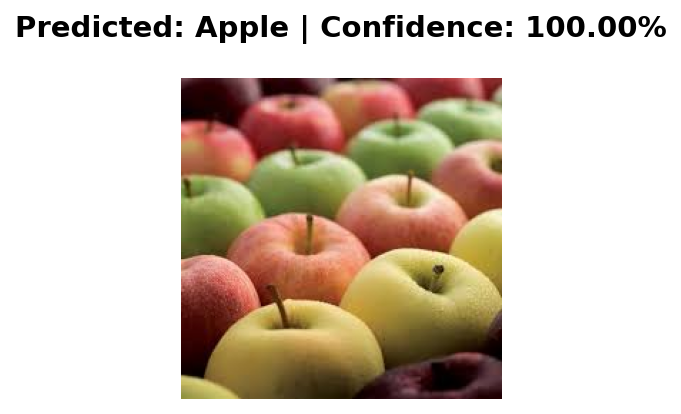

Предсказание: Apple
Уверенность: 1.0000
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\Apple\img_1161.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 10 ---


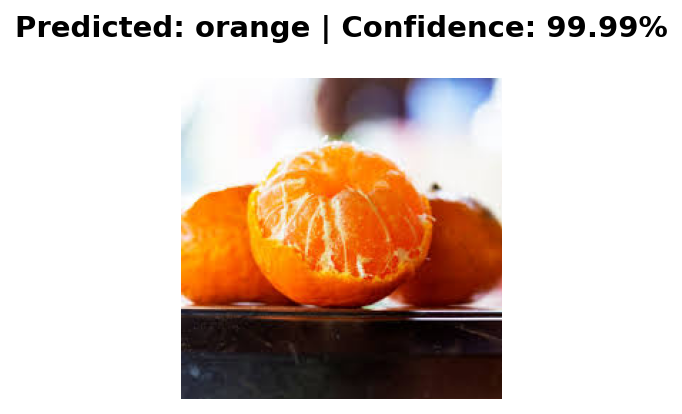

Предсказание: orange
Уверенность: 0.9999
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\orange\img_1171.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 11 ---


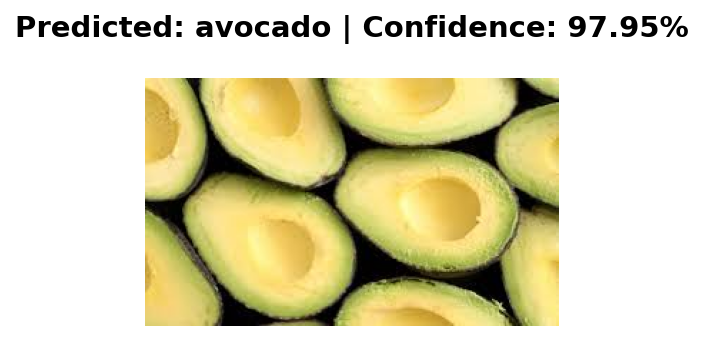

Предсказание: avocado
Уверенность: 0.9795
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\avocado\img_1041.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 12 ---


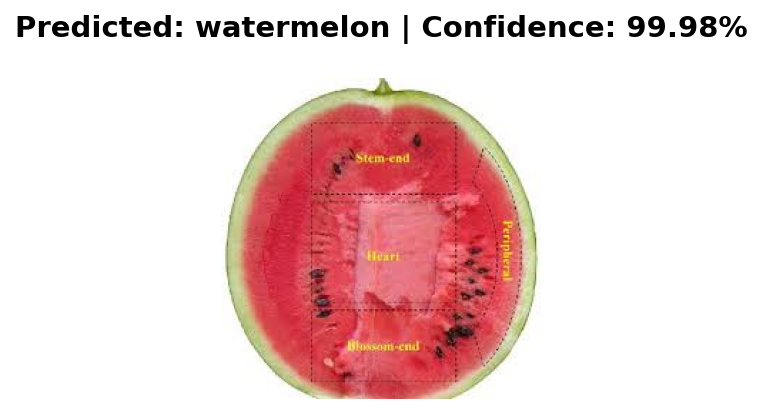

Предсказание: watermelon
Уверенность: 0.9998
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\watermelon\img_1261.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 13 ---


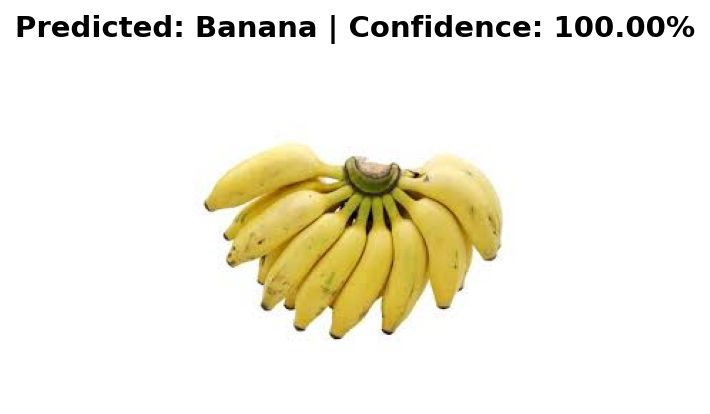

Предсказание: Banana
Уверенность: 1.0000
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\Banana\img_1041.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 14 ---


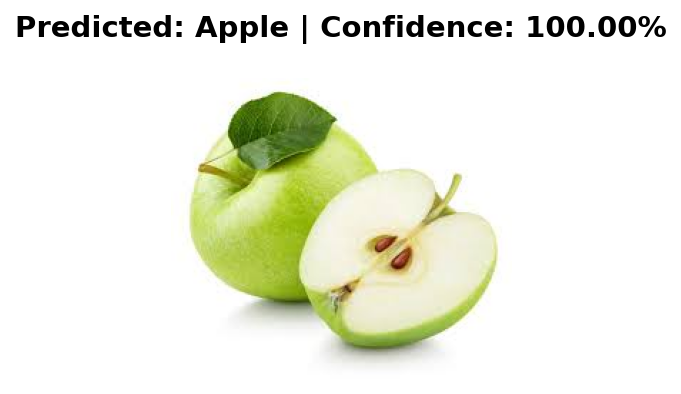

Предсказание: Apple
Уверенность: 1.0000
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\Apple\img_1061.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 15 ---


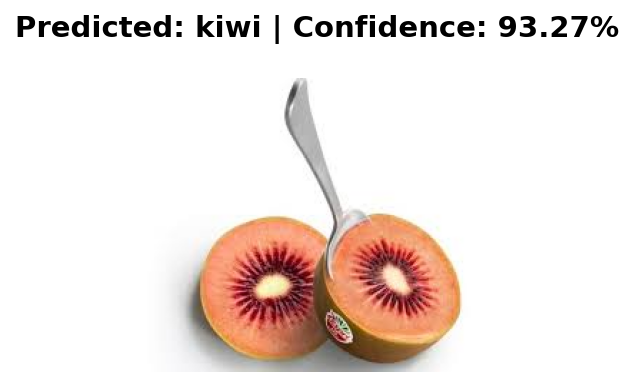

Предсказание: kiwi
Уверенность: 0.9327
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\kiwi\img_1001.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 16 ---


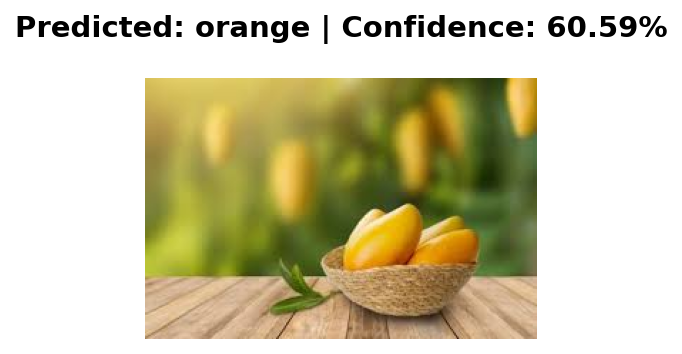

Предсказание: orange
Уверенность: 0.6059
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\mango\img_1021.jpeg
❌ Ошибка! Истинный класс: mango
----------------------------------------

--- Изображение 17 ---


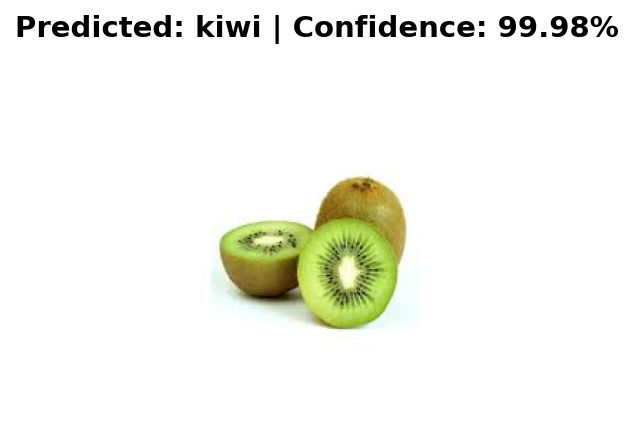

Предсказание: kiwi
Уверенность: 0.9998
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\kiwi\img_1151.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 18 ---


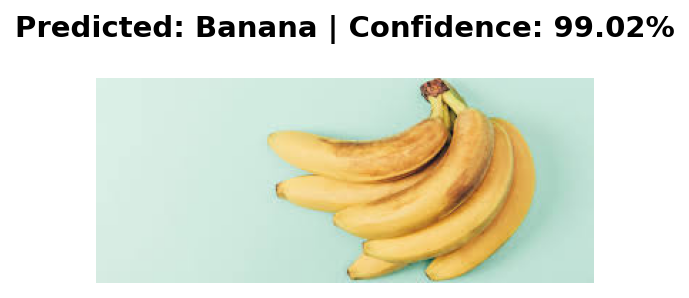

Предсказание: Banana
Уверенность: 0.9902
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\Banana\img_1061.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 19 ---


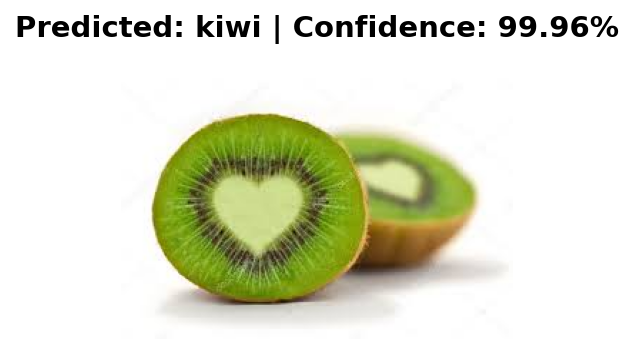

Предсказание: kiwi
Уверенность: 0.9996
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\kiwi\img_1141.jpeg
✅ Правильно!
----------------------------------------

--- Изображение 20 ---


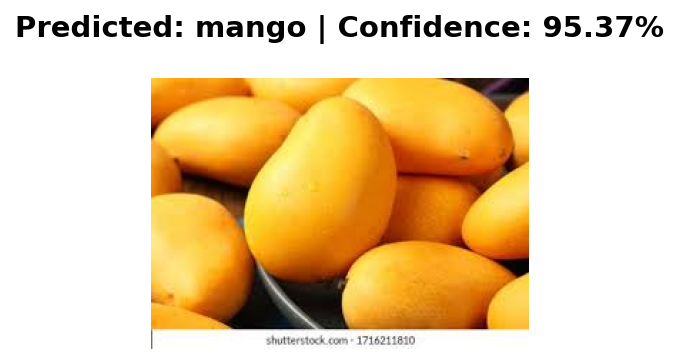

Предсказание: mango
Уверенность: 0.9537
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\mango\img_1201.jpeg
✅ Правильно!
----------------------------------------

Тестируем изображение: img_31.jpeg


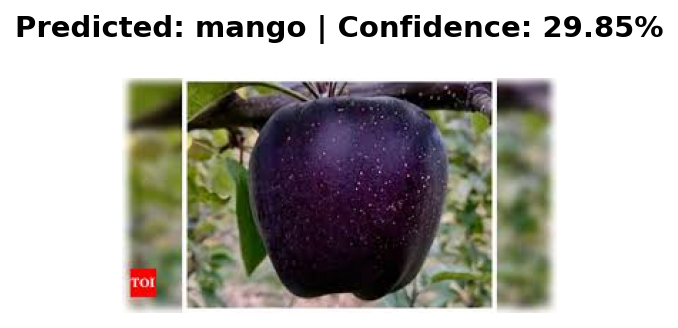

Предсказание: mango
Уверенность: 0.2985
Путь к изображению: C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\apple\img_31.jpeg
❌ Ошибка! Истинный класс: apple


In [37]:
# Функции для предсказания
def predict_image(image_path, model, class_names, transform, device):
    # image_path - путь к картинке
    # model - обученная нейросеть
    # class_names - список названий классов
    # transform - как обрабатывать картинку перед подачей в сеть
    # device - где выполнять вычисления (GPU или CPU)
    """Предсказывает класс для одного изображения"""
    model.eval()
    
    # Загружаем и преобразуем изображение
    image = Image.open(image_path).convert('RGB')

    # Обрабатываем картинку для нейросети.
    # transform(image) - применяем все преобразования (изменение размера, нормализация и т.д.)
    # .unsqueeze(0) - добавляем "batch dimension". Нейросеть ожидает не одну картинку, а ПАЧКУ картинок. Эта команда превращает [3, 224, 224] в [1, 3, 224, 224] (1 картинка в пачке)
    # .to(device) - перемещаем картинку на то же устройство, где находится модель
    image_tensor = transform(image).unsqueeze(0).to(device)  # Добавляем batch dimension
    
    # Не запоминаем градиенты
    with torch.no_grad():

        # Пропускаем картинку через нейросеть.
        # Картинка проходит через все слои ResNet, и на выходе получаем "сырые" числа.
        # Пример выхода: outputs = [2.1, -1.3, 0.8] - это НЕ вероятности, а "логиты"
        # Логиты — это выходные данные нейронной сети до применения функции активации
        # Они представляют собой ненормализованные вероятности принадлежности объекта определённому классу. 
        # Логиты часто используются в задачах классификации, где цель — предсказать класс входных данных
        outputs = model(image_tensor)

        # Превращаем "сырые" числа в вероятности.
        # Берет числа: [2.1, -1.3, 0.8]
        # Превращает в: [0.85, 0.05, 0.10] (сумма = 1.0)
        # Теперь это вероятности
        probabilities = F.softmax(outputs, dim=1)

        # Находим самую высокую вероятность и какой это класс
        confidence, predicted = torch.max(probabilities, 1)
    
    #  Превращаем индекс класса в его название.
    predicted_class = class_names[predicted.item()]

    # Превращаем тензор с одним числом в обычное Python число
    confidence_value = confidence.item()
    
    return predicted_class, confidence_value

# def predict_single_image(image_path, model, class_names, transform, device):
#     """Предсказывает класс и отображает результат"""
#     predicted_class, confidence = predict_image(image_path, model, class_names, transform, device)
    
#     # Отображаем результат
#     image = Image.open(image_path)
#     plt.figure(figsize=(10, 8))
    
#     plt.imshow(image)
#     plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.4f}', 
#               fontsize=14, pad=20)
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()
    
#     print(f"Предсказание: {predicted_class}")
#     print(f"Уверенность: {confidence:.4f}")
#     print(f"Путь к изображению: {image_path}")
    
#     return predicted_class, confidence

def predict_single_image(image_path, model, class_names, transform, device):
    """Предсказывает класс и отображает результат в оригинальном размере"""
    predicted_class, confidence = predict_image(image_path, model, class_names, transform, device)
    
    # Загружаем оригинальное изображение
    original_image = Image.open(image_path)
    width, height = original_image.size
    
    # Рассчитываем размер фигуры в дюймах на основе размера изображения
    # Предполагаем стандартное разрешение 100 DPI
    fig_width = width / 100  # переводим пиксели в дюймы
    fig_height = height / 100
    
    # Ограничиваем максимальный размер (чтобы не вылезало за экран)
    max_width = 20  # дюймов
    max_height = 15  # дюймов
    
    if fig_width > max_width:
        scale_factor = max_width / fig_width
        fig_width = max_width
        fig_height = fig_height * scale_factor
    
    if fig_height > max_height:
        scale_factor = max_height / fig_height
        fig_height = max_height
        fig_width = fig_width * scale_factor
    
    # Увеличиваем DPI для максимальной четкости
    plt.figure(figsize=(fig_width, fig_height), dpi=150)
    
    # Показываем изображение без интерполяции (как есть)
    plt.imshow(original_image)
    plt.title(f'Predicted: {predicted_class} | Confidence: {confidence:.2%}', 
              fontsize=14, pad=20, fontweight='bold')
    plt.axis('off')
    
    # Убираем все отступы, чтобы изображение занимало всю область
    plt.tight_layout(pad=0)
    plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
    
    plt.show()
    
    print(f"Предсказание: {predicted_class}")
    print(f"Уверенность: {confidence:.4f}")
    print(f"Путь к изображению: {image_path}")
    
    return predicted_class, confidence

# Тестируем модель на тестовых изображениях
# Получаем список классов из датасета
class_names = train_dataset.classes
print(f"Доступные классы: {class_names}")

# Ищем изображения в тестовой папке
test_images = []
dataset_path = r'C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data'

for fruit_class in class_names:
    # Пробуем разные расширения файлов
    for ext in ['*.jpeg', '*.jpg', '*.png']:
        class_path = os.path.join(dataset_path, 'test', fruit_class, ext)
        class_images = glob.glob(class_path)
        if class_images:
            test_images.extend(class_images[:20])  # Берем по 20 изображений от каждого класса
            print(f"Найдено {len(class_images)} изображений для класса {fruit_class}")
            break

print(f"\nВсего найдено {len(test_images)} тестовых изображений")

# Тестируем на нескольких случайных изображениях
if test_images:
    # random.sample(список, количество) - выбирает случайные элементы БЕЗ повторений
    # min(20, len(test_images)) - берем 20 картинок ИЛИ меньше, если всего картинок меньше 20
    selected_images = random.sample(test_images, min(20, len(test_images)))
    
    print(f"\nТестируем на {len(selected_images)} случайных изображениях:")
    
    for i, image_path in enumerate(selected_images):
        print(f"\n--- Изображение {i+1} ---")

        # os.path.dirname(image_path) - получает путь к папке
        # os.path.basename(...) - получает имя папки
        # Пример: image_path = ".../test/apple/img1.jpeg" → true_class = "apple"
        true_class = os.path.basename(os.path.dirname(image_path))
        predicted_class, confidence = predict_single_image(
            image_path, model, class_names, val_transform, device
        )
        
        # Проверяем правильность предсказания
        if predicted_class.lower() == true_class.lower():
            print("✅ Правильно!")
        else:
            print(f"❌ Ошибка! Истинный класс: {true_class}")
        
        print("-" * 40)

# Функция для тестирования конкретного изображения
def test_specific_image(image_path):
    """Тестирует конкретное изображение"""
    if not os.path.exists(image_path):
        print(f"Файл не найден: {image_path}")
        return
    
    print(f"\nТестируем изображение: {os.path.basename(image_path)}")
    predicted_class, confidence = predict_single_image(
        image_path, model, class_names, val_transform, device
    )
    true_class = os.path.basename(os.path.dirname(image_path))
    if predicted_class.lower() == true_class.lower():
        print("✅ Правильно!")
    else:
        print(f"❌ Ошибка! Истинный класс: {true_class}")
    return predicted_class, confidence

# Пример тестирования конкретного изображения
specific_image = r'C:\Users\user\Desktop\MIPT year 2\Инженерный практикум\Working_directory\Convolutional-Neural-Network\fruits_data\MY_data\test\apple\img_31.jpeg'
if os.path.exists(specific_image):
    test_specific_image(specific_image)
else:
    print(f"Файл не найден: {specific_image}")

